In [1]:
from pathlib import Path
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
from fastprogress.fastprogress import master_bar, progress_bar
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = Path('data/')
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
bs = 64
num_workers = 6
epochs = 2

In [3]:
df_train = pd.read_csv(path/'train.csv')
df_test = pd.read_csv(path/'test.csv')

train_files = list((path/'train').iterdir())
train_id_lbl = dict(df_train[['Id','Pawpularity']].values)



normalize = transforms.Normalize(mean=imagenet_mean,
                                 std=imagenet_std)

unnormalize = transforms.Normalize((-imagenet_mean / imagenet_std).tolist(), (1.0 / imagenet_std).tolist())

train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])


class PetsDataset(Dataset):
    def __init__(self,files=None,id_lbl=None,transforms=None):
        self.files = files
        self.id_lbl = id_lbl
        self.transforms = transforms
    
    def __getitem__(self,index):
        file_path = self.files[index] 
        img = Image.open(file_path)
        if self.transforms:
            img = self.transforms(img)
        label = self.id_lbl[file_path.stem]
        label = label/100
        return img, label
    
    def __len__(self):
        return len(self.files)
    
    def show(self,index=None):
        if not index :
            index = random.randint(0,len(self.files))
        img, lbl = self.__getitem__(index)
        img = unnormalize(img).permute(1,2,0).clip(0,1)
        plt.imshow(img)

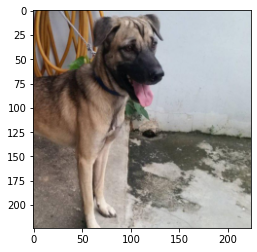

In [5]:
train_ds = PetsDataset(files=train_files, id_lbl=train_id_lbl,transforms=train_tfms)
train_ds.show()

In [7]:
train_dl = DataLoader(dataset=train_ds,batch_size=bs,shuffle=True,num_workers=num_workers)
model = models.resnet34(pretrained=True)
model.fc = nn.LazyLinear(1)
model = model.to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr = 1e-4,
                            momentum=0.9,
                            nesterov=True,
                            weight_decay=1e-4)

def training_step(epoch, train_dl,model,optimizer,loss_fn,mb):
    model.train()
    model = model.to(device)
    for batch_idx, (xb, yb) in enumerate(progress_bar((train_dl), parent=mb)):
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb).view(-1)
        loss = loss_fn(output,yb)
        loss.backward()
        optimizer.step()
        for param in model.parameters():
            param.grad = None
     

In [7]:
   
mb = master_bar(range(epochs))
for epoch in mb:
    training_step(epoch, train_dl, model,optimizer,loss_fn,mb)